## Description

In this notebook, we estimate the concentrations of lipid ions in pixels of our MS images.  
We use lipid ions detected in Notebook 3.  
We compare the resulting spatial distributions with single ion images of the same lipids (i.e. the spatial distributions of peak intensities of the lipids, taken from unprocessed MS images).   

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession IMS:1000491 found with incorrect name "line scan left right". Updating name to "linescan left right".
  warn(


In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/ciach/Py3Env/lib/python3.8/site-packages/pyimzml/ontology/ontology.py:86: UserWarning: Accession MS:1000584 found with incorrect name "mzML file". 

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
lipid_formulas = {n : [] for n in image_names}
for i, n in enumerate(image_names):
    with open(n + '_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            lipid_formulas[n].append(l[0])
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 101 formulas for cerebellum
Loaded 43 formulas for bladder


In [10]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

## Regression settings

In [11]:
MTD = 0.01
MTD_th = 0.015

## Lipid quantification

Estimation through regression on MS images in centroided mode:

In [12]:
# masserstein_estimation = {n : [] for n in image_names}
# masserstein_coordinates = {n : [] for n in image_names}
# for n in image_names:
#     print('Processing image:', n, '(centroid mode)')
#     s = time()
#     for idx, (xcoord,ycoord,zcoord) in enumerate(centroided_images[n].coordinates):
#         if not idx % 10000:
#             print('Processing pixel number', idx)
# #         if idx % 10: 
# #             continue
#         mz, intsy = centroided_images[n].getspectrum(idx)
#         selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
#         mz = mz[selected_range]
#         intsy = intsy[selected_range]
# #         selected_peaks = intsy >= 1e-4*max(intsy)
# #         mz = mz[selected_peaks]
# #         intsy = intsy[selected_peaks]
#         pixel_spectrum = Spectrum(confs=list(zip(mz, intsy)))
#         pixel_spectrum.normalize()
#         regression = estimate_proportions(pixel_spectrum, lipid_spectra[n], 
#                                           MTD=MTD, MTD_th=MTD_th, MDC=1e-06, MMD=0.1, progress=False)
#         masserstein_estimation[n].append(regression['proportions'])
#         masserstein_coordinates[n].append((ycoord-1, xcoord-1))
#     e = time()
#     print('Regression time:', e-s)
# masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
# masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

Save the estimation results:

In [13]:
# for n in image_names:
#     frms = lipid_formulas[n]
#     crd = masserstein_coordinates[n]
#     est = masserstein_estimation[n]
#     with open(n + '_masserstein_quantification.tsv', 'w') as h:
#         h.write('X\tY\t' + '\t'.join(frms) + '\n')
#         for i in range(crd.shape[0]):
#             h.write(str(crd[i, 0]) + '\t' + str(crd[i,1]) + '\t' + '\t'.join(list(map(str, est[i]))) + '\n')


Load the estimation results from a previous program run: 

In [14]:
masserstein_estimation = {n : [] for n in image_names}
masserstein_coordinates = {n : [] for n in image_names}
for n in image_names:
    frms = lipid_formulas[n]
    with open(n + '_masserstein_quantification.tsv') as h:
        header = next(h)
        header = header.strip().split('\t')
        header_formulas = header[2:]
        formula_order = [header_formulas.index(f) for f in frms]
        for l in h:
            l = l.strip().split('\t')
            masserstein_coordinates[n].append((int(l[0]), int(l[1])))
            vec = list(map(float, l[2:]))
            vec = [vec[i] for i in formula_order]
            masserstein_estimation[n].append(vec)
masserstein_estimation = {n : np.array(masserstein_estimation[n]) for n in image_names}
masserstein_coordinates = {n : np.array(masserstein_coordinates[n]) for n in image_names}

Estimation through monoisotopic peak intensity on MS images in profile mode:  
(note: we use profile mode here because centroid mode can lose hidden peaks; profile mode is more accurate; this is more important for peak-based images than for masserstein-based images)

In [15]:
intensities = {n : [] for n in image_names}
intensity_coordinates = {n : [] for n in image_names}
for n in image_names:
    print('Processing image:', n, '(profile mode)')
    monoisotopic_masses = [s.confs[0][0] for s in lipid_spectra[n]]
    s = time()
    for idx, (xcoord,ycoord,zcoord) in enumerate(profile_images[n].coordinates):
        if not idx % 10000:
            print('Processing pixel number', idx)
        mz, intsy = profile_images[n].getspectrum(idx)
        selected_range = (analyzed_mass_range[0] <= mz)*(mz <= analyzed_mass_range[1])
        mz = mz[selected_range]
        intsy = intsy[selected_range]
        intsy /= np.trapz(intsy, mz)
        peak_intensities = np.interp(monoisotopic_masses, mz, intsy)
        intensities[n].append(peak_intensities)
        intensity_coordinates[n].append((ycoord-1, xcoord-1))
    e = time()
    print('Regression time:', e-s)
intensities = {n : np.array(intensities[n]) for n in image_names}
intensity_coordinates = {n : np.array(intensity_coordinates[n]) for n in image_names}

Processing image: cerebellum (profile mode)
Processing pixel number 0
Regression time: 3.819927215576172
Processing image: bladder (profile mode)
Processing pixel number 0
Processing pixel number 10000
Processing pixel number 20000
Processing pixel number 30000
Regression time: 11.893412828445435


<IPython.core.display.Javascript object>


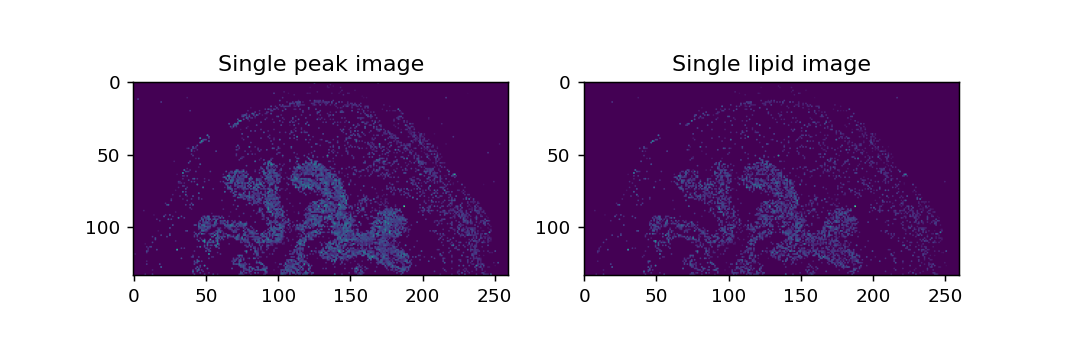

In [16]:
test_name = 'bladder'
test_lipid_id = 8
test_masserstein = np.zeros(image_shapes[test_name])
test_intensity = np.zeros(image_shapes[test_name])
for i, l in enumerate(masserstein_coordinates[test_name]):
    test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]
for i, l in enumerate(intensity_coordinates[test_name]):
    test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('Single peak image')
plt.imshow(test_intensity)
plt.subplot(122)
plt.title('Single lipid image')
plt.imshow(test_masserstein)
plt.show()

## Comparing the estimated spatial distributions

In [17]:
signal_correlations = {'cerebellum': [], 'bladder': []}
for n in image_names:
    # in case we only want to analyze a subset of pixels:
    massr_crd_list = [tuple(x) for x in masserstein_coordinates[n]]
    intsy_crd_list = [tuple(x) for x in intensity_coordinates[n]]
    common_pixels = list(set(massr_crd_list) & set(intsy_crd_list))
    idx_in_intsy = [intsy_crd_list.index(x) for x in common_pixels]
    idx_in_massr = [massr_crd_list.index(x) for x in common_pixels]
    for lipid_id in range(len(lipid_spectra[n])):
        intsy_vec = [intensities[n][x, lipid_id] for x in idx_in_intsy]
        massr_vec = [masserstein_estimation[n][x, lipid_id] for x in idx_in_massr]
        cor = np.corrcoef(intsy_vec, massr_vec)
        signal_correlations[n].append(cor[0,1])

<IPython.core.display.Javascript object>


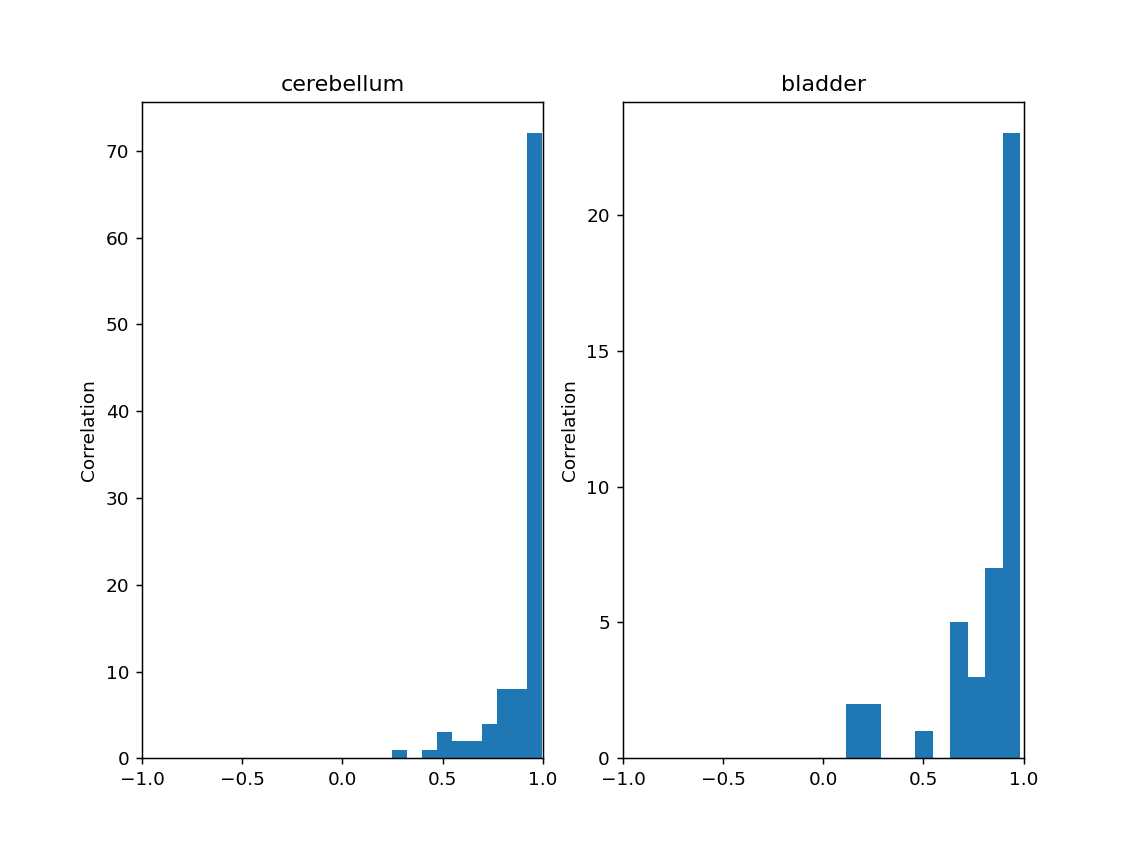

In [18]:
plt.figure()
plt.subplot(121)
plt.title(image_names[0])
plt.hist(signal_correlations[image_names[0]])
plt.ylabel('Correlation')
plt.xlim(-1, 1)
plt.subplot(122)
plt.title(image_names[1])
plt.hist(signal_correlations[image_names[1]])
plt.ylabel('Correlation')
plt.xlim(-1, 1)
plt.show()

In [19]:
np.argmin(signal_correlations['bladder'])

30

<IPython.core.display.Javascript object>


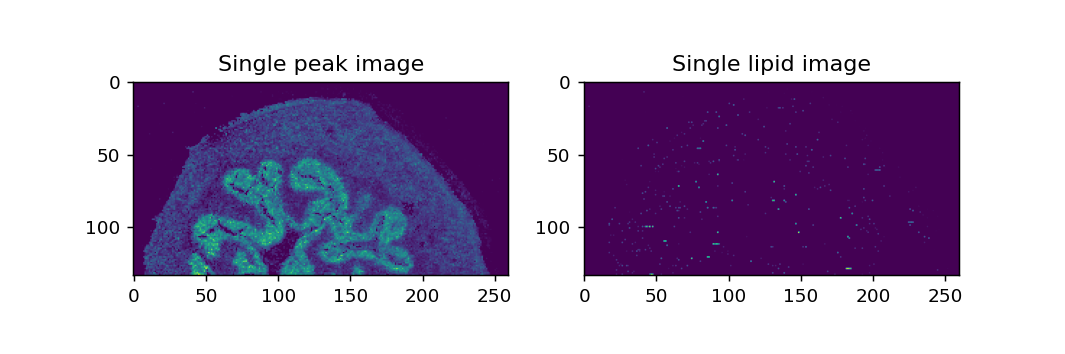

In [20]:
test_name = 'bladder'
test_lipid_id = 30
test_masserstein = np.zeros(image_shapes[test_name])
test_intensity = np.zeros(image_shapes[test_name])
for i, l in enumerate(masserstein_coordinates[test_name]):
    test_masserstein[l[0], l[1]] = masserstein_estimation[test_name][i, test_lipid_id]    
for i, l in enumerate(intensity_coordinates[test_name]):
    test_intensity[l[0], l[1]] = intensities[test_name][i, test_lipid_id]

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.title('Single peak image')
plt.imshow(test_intensity)
plt.subplot(122)
plt.title('Single lipid image')
plt.imshow(test_masserstein)
plt.show()

## Generating images

We'll save ion images for each lipid, obtained from peak intensities and estimated quantities.  

In [21]:
# for n in image_names:
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):
#         intsy_image = np.zeros(image_shapes[n])
#         decon_image = np.zeros(image_shapes[n])
#         for i, l in enumerate(intensity_coordinates[n]):
#             intsy_image[l[0], l[1]] = intensities[n][i,lipid_id]
#         for i, l in enumerate(masserstein_coordinates[n]):
#             decon_image[l[0], l[1]] = masserstein_estimation[n][i,lipid_id]
        
#         plt.figure()# figsize=(0.1*image_shapes[n][1], 0.1*2*image_shapes[n][0]))
#         plt.subplot(121)
#         plt.title(str(lipid_id) + ' peak at %.2f' % lipid_sp.confs[0][0])
#         plt.imshow(intsy_image)
#         plt.axis('off')
#         plt.subplot(122)
#         plt.title(str(lipid_id) + ' masserstein')
#         plt.imshow(decon_image)
#         plt.axis('off')
#         plt.tight_layout()
#         plt.savefig(n + '_ion_images/%i.png' % lipid_id, dpi=300)
#         plt.close()

## Segmentation

First, we'll compute K-means segmentations based on peak intensities. 

In [22]:
nclust = 3
km = KMeans(n_clusters=nclust)

In [23]:
intensity_segmentation = {n : np.zeros(intensities[n].shape) for n in image_names}
for n in image_names:
    intsy_matrix = intensities[n]
    for j in range(intsy_matrix.shape[1]):
        segm = km.fit_predict(intsy_matrix[:,j:(j+1)])
        cluster_centers = km.cluster_centers_[:,0]
        cluster_order = np.argsort(np.argsort(cluster_centers))
        relabeled_segm = cluster_order[segm]
        intensity_segmentation[n][:,j] = relabeled_segm
    

<IPython.core.display.Javascript object>


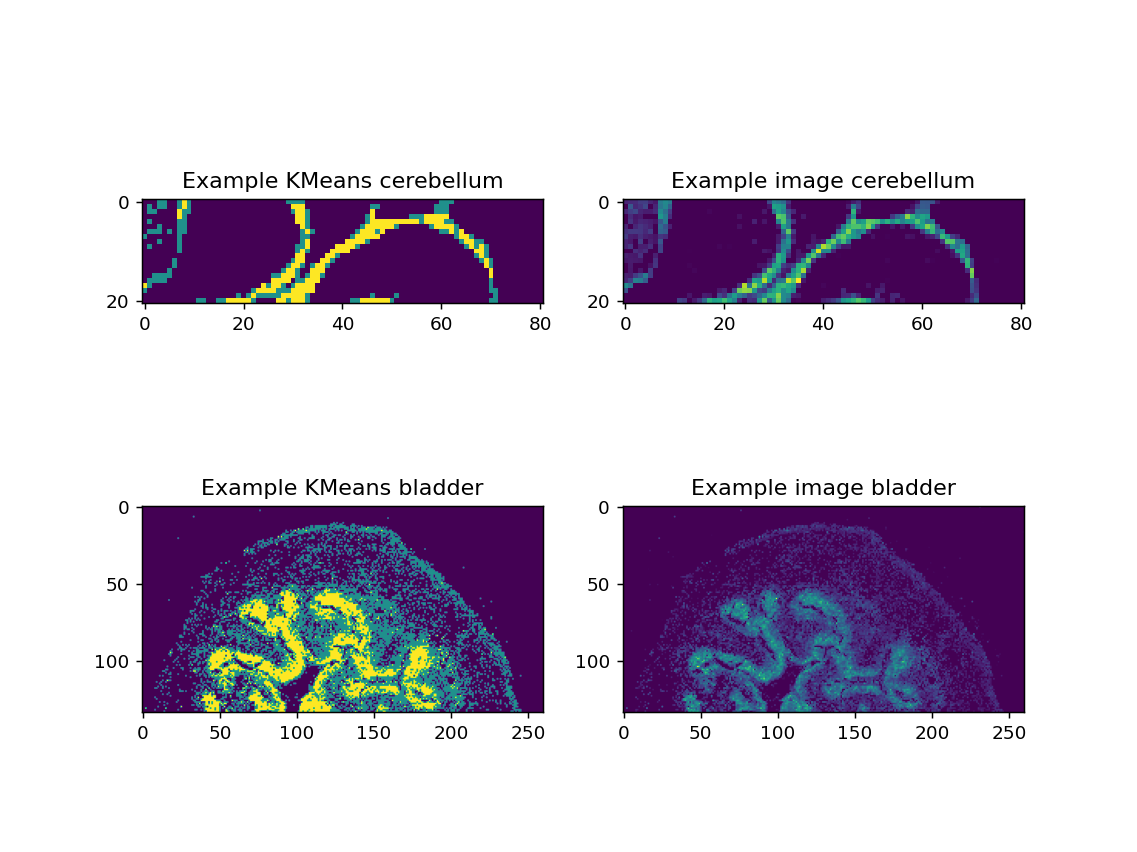

In [24]:
example_cerebellum_segm = np.zeros(image_shapes['cerebellum'])
example_cerebellum_pimg = np.zeros(image_shapes['cerebellum'])
example_bladder_segm = np.zeros(image_shapes['bladder'])
example_bladder_pimg = np.zeros(image_shapes['bladder'])
lipid_id = 12
for i, l in enumerate(intensity_coordinates['cerebellum']):
    example_cerebellum_segm[l[0], l[1]] = intensity_segmentation['cerebellum'][i, lipid_id]
    example_cerebellum_pimg[l[0], l[1]] = intensities['cerebellum'][i, lipid_id]
for i, l in enumerate(intensity_coordinates['bladder']):
    example_bladder_segm[l[0], l[1]] =  intensity_segmentation['bladder'][i, lipid_id]
    example_bladder_pimg[l[0], l[1]] = intensities['bladder'][i, lipid_id]
        
plt.figure()
plt.subplot(221)
plt.title('Example KMeans cerebellum')
plt.imshow(example_cerebellum_segm)
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(example_cerebellum_pimg)
plt.subplot(223)
plt.title('Example KMeans bladder')
plt.imshow(example_bladder_segm)
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(example_bladder_pimg)


Now, compute spatial-DGMM segmentations based on masserstein estimates.  
First, load R and the Cardinal package

In [25]:
%load_ext rpy2.ipython

In [26]:
%R suppressPackageStartupMessages(library('Cardinal'))

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


Convert our intensity arrays to Pandas DataFrames

In [27]:
cerebellum_df = pd.DataFrame(masserstein_estimation['cerebellum'][:, 10:14])
cerebellum_coords = [list(x) for x in masserstein_coordinates['cerebellum']]
bladder_df = pd.DataFrame(masserstein_estimation['bladder'][:, 10:14])
bladder_coords = [list(x) for x in masserstein_coordinates['bladder']]
cerebellum_df.head()

,0,1,2,3
0,0.004155,0.013313,-0.0,0.0
1,0.008179,-0.000000,0.0,0.0
2,0.003687,0.013329,-0.0,0.0
3,-0.000000,0.006489,-0.0,-0.0
4,0.003341,-0.000000,-0.0,-0.0


In [28]:
-0.0 + 0.0

0.0

Import the data into R

In [29]:
%R -i cerebellum_df 
%R -i cerebellum_coords
%R -i bladder_df
%R -i bladder_coords

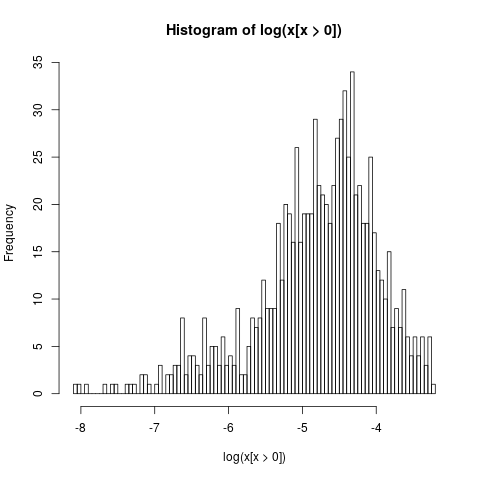

In [30]:
%%R 
x<- cerebellum_df[['1']]
hist(log(x[x>0]), breaks=80)

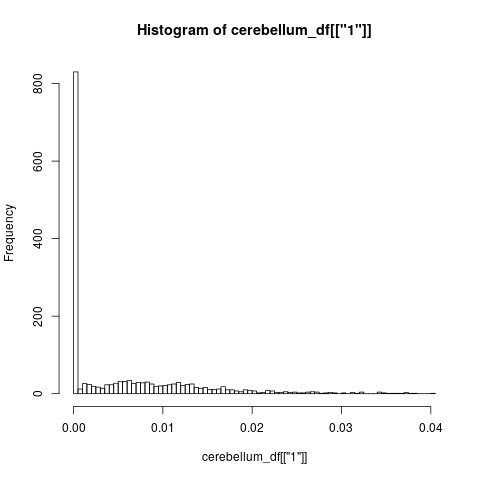

In [31]:
%%R 

hist(cerebellum_df[['1']], breaks=120)

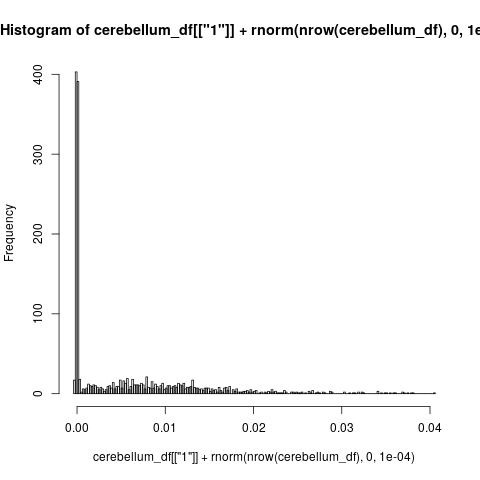

In [32]:
%%R 

hist(cerebellum_df[['1']] + rnorm(nrow(cerebellum_df), 0, 0.0001), breaks=200)

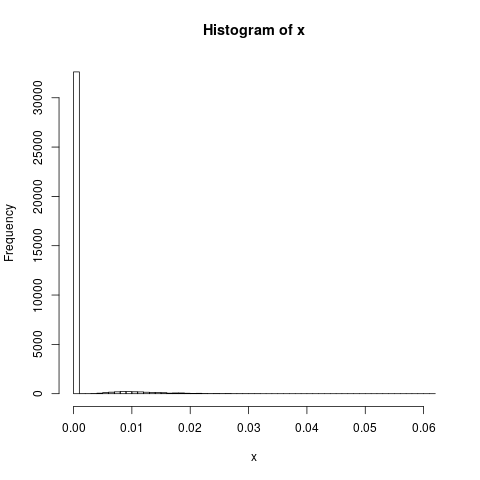

In [33]:
%%R 
x<- bladder_df[['1']]
hist(x, breaks=80)

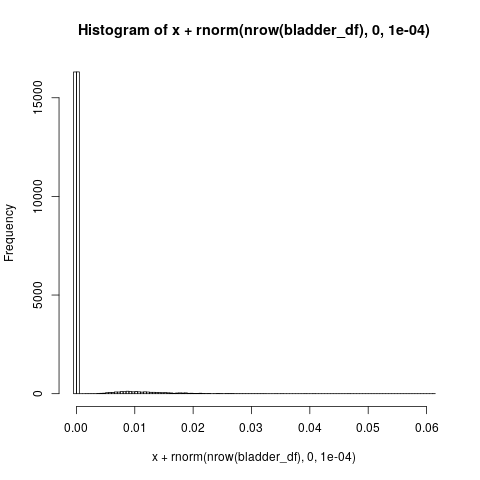

In [34]:
%%R 
hist(x + rnorm(nrow(bladder_df), 0, 0.0001), breaks=120)

In [35]:
%R head(cerebellum_coords)

array([[20, 20, 20, ...,  0,  0,  0],
       [ 0,  1,  2, ..., 78, 79, 80]], dtype=int32)

Construct the images:

In [66]:
%%R 


cerebellum_fdata <- MassDataFrame(mz=1:ncol(cerebellum_df), row.names=as.character(1:ncol(cerebellum_df)))
cerebellum_run <- factor(rep("run0", nrow(cerebellum_df)))
cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=t(cerebellum_coords[c(2,1), ]))

cerebellum_image <- MSImagingExperiment(imageData=t(cerebellum_df) + rnorm(nrow(cerebellum_df), 0, 0.000001),
                                        featureData=cerebellum_fdata,
                                        pixelData=cerebellum_pdata)

In [67]:
%%R 

bladder_fdata <- MassDataFrame(mz=1:ncol(bladder_df), row.names=as.character(1:ncol(bladder_df)))
bladder_run <- factor(rep("run0", nrow(bladder_df)))
bladder_pdata <- PositionDataFrame(run=bladder_run, coord=t(bladder_coords[c(2,1), ]))

bladder_image <- MSImagingExperiment(imageData=t(bladder_df) + rnorm(nrow(bladder_df), 0, 0.000001),
                                        featureData=bladder_fdata,
                                        pixelData=bladder_pdata)

Visualize lipid images to verify that the data is loaded correctly: 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



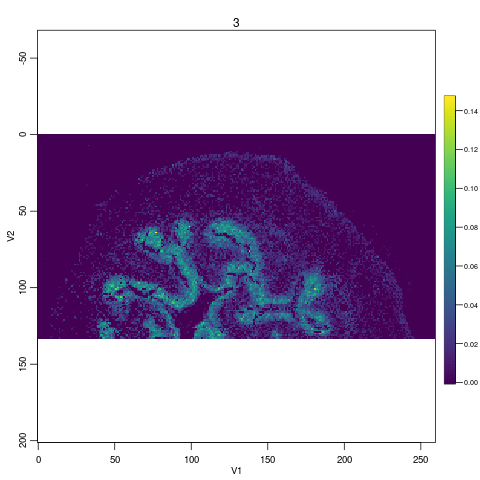

In [38]:
%%R 
image(bladder_image,feature=3)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In plot.window(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 2: 
R[write to console]: In plot.xy(xy, type, ...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In axis(side = side, at = at, labels = labels, ...) :
R[write to console]: 
 
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 5: 
R[write to console]: In box(...) :
R[write to console]:  "useS4" is not a graphical parameter

R[write to console]: 6: 
R[write to console]: In title(...) :
R[write to console]:  "useS4" is not a graphical parameter



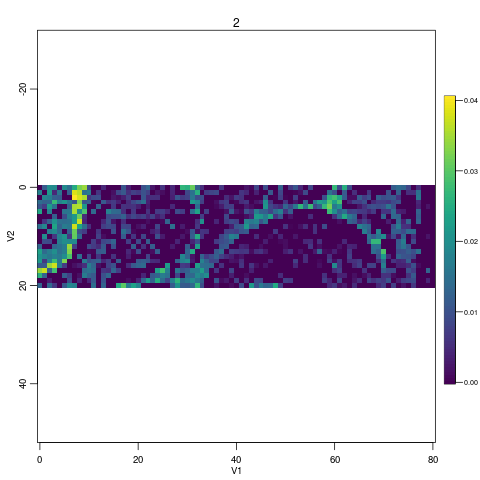

In [39]:
%%R 
image(cerebellum_image,feature=2)

Run the spatialDGMM segmentations:

In [70]:
%%R 

cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=c(1, 10, 20), k=3, method="adaptive",
                                init = 'gmm', tol=1e-12, iter.max=2000)

calculating spatial weights...
segmenting feature images...
r = 3, k = 3, feature = 1 . 
r = 3, k = 3, feature = 2 . 
r = 3, k = 3, feature = 3 . 
r = 3, k = 3, feature = 4 . 
r = 5, k = 3, feature = 1 . 
r = 5, k = 3, feature = 2 . 
r = 5, k = 3, feature = 3 . 
r = 5, k = 3, feature = 4 . 
r = 8, k = 3, feature = 1 . 
r = 8, k = 3, feature = 2 . 
r = 8, k = 3, feature = 3 . 
r = 8, k = 3, feature = 4 . 


In [ ]:
%%R 

image(cerebellum_sdgmm, values='class')

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



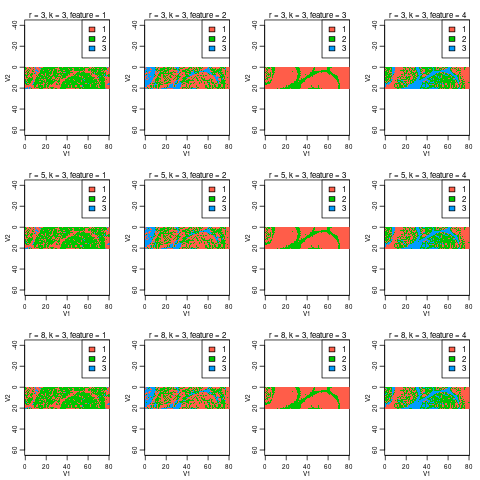

In [69]:
%%R 

image(cerebellum_sdgmm, values='class')

In [42]:
%%R 

bladder_sdgmm <- spatialDGMM(bladder_image, r=5, k=3, method="adaptive", dist='chebyshev',
                             init = 'gmm', tol=1e-12, iter.max=2000)

calculating spatial weights...
segmenting feature images...
r = 5, k = 4, feature = 3 . 
r = 5, k = 4, feature = 4 .
Error in get(as.character(FUN), mode = "function", envir = envir) : 
  object 'as.SimpleList' of mode 'function' was not found


RInterpreterError: Failed to parse and evaluate line '\nbladder_sdgmm <- spatialDGMM(bladder_image, r=5, k=4, method="adaptive", dist=\'chebyshev\',\n                             init = \'gmm\', tol=1e-12, iter.max=2000)\n'.
R error message: 'Error in get(as.character(FUN), mode = "function", envir = envir) : \n  object \'as.SimpleList\' of mode \'function\' was not found'
R stdout:
calculating spatial weights...
segmenting feature images...
r = 5, k = 4, feature = 3 . 
r = 5, k = 4, feature = 4 .

In [ ]:
%%R 

image(bladder_sdgmm, values='class')

In [ ]:
%%R

cerebellum_segments <- sapply(1:ncol(cerebellum_df), function(i) as.numeric(resultData(cerebellum_sdgmm)[[i]]$class))
bladder_segments <- sapply(1:ncol(bladder_df), function(i) as.numeric(resultData(bladder_sdgmm)[[i]]$class))

In [ ]:
cerebellum_sdgmm_segmentation = %Rget cerebellum_segments
bladder_sdgmm_segmentation = %Rget bladder_segments

In [ ]:
example_cerebellum_segm = np.zeros(image_shapes['cerebellum'])
example_cerebellum_pimg = np.zeros(image_shapes['cerebellum'])
example_bladder_segm = np.zeros(image_shapes['bladder'])
example_bladder_pimg = np.zeros(image_shapes['bladder'])
lipid_id = 2
for i, l in enumerate(masserstein_coordinates['cerebellum']):
    example_cerebellum_segm[l[0], l[1]] = cerebellum_sdgmm_segmentation[i, lipid_id]
    example_cerebellum_pimg[l[0], l[1]] = intensities['cerebellum'][i, lipid_id]
for i, l in enumerate(intensity_coordinates['bladder']):
    example_bladder_segm[l[0], l[1]] =  bladder_sdgmm_segmentation[i, lipid_id]
    example_bladder_pimg[l[0], l[1]] = intensities['bladder'][i, lipid_id]
        
plt.figure()
plt.subplot(221)
plt.title('Example sDGMM cerebellum')
plt.imshow(example_cerebellum_segm)
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(example_cerebellum_pimg)
plt.subplot(223)
plt.title('Example sDGMM bladder')
plt.imshow(example_bladder_segm)
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(example_bladder_pimg)


<IPython.core.display.Javascript object>


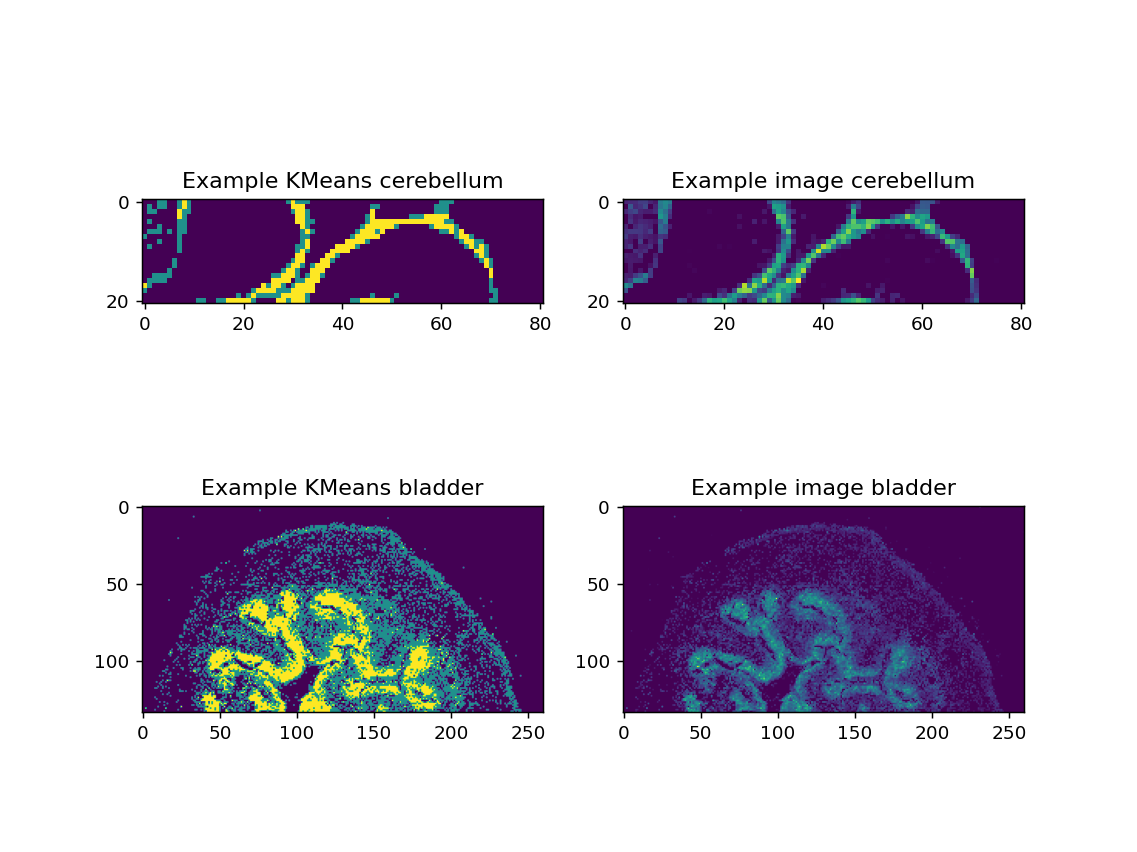

In [88]:
example_cerebellum_segm = np.zeros(image_shapes['cerebellum'])
example_cerebellum_pimg = np.zeros(image_shapes['cerebellum'])
example_bladder_segm = np.zeros(image_shapes['bladder'])
example_bladder_pimg = np.zeros(image_shapes['bladder'])
lipid_id = 12
for i, l in enumerate(intensity_coordinates['cerebellum']):
    example_cerebellum_segm[l[0], l[1]] = intensity_segmentation['cerebellum'][i, lipid_id]
    example_cerebellum_pimg[l[0], l[1]] = intensities['cerebellum'][i, lipid_id]
for i, l in enumerate(intensity_coordinates['bladder']):
    example_bladder_segm[l[0], l[1]] =  intensity_segmentation['bladder'][i, lipid_id]
    example_bladder_pimg[l[0], l[1]] = intensities['bladder'][i, lipid_id]
        
plt.figure()
plt.subplot(221)
plt.title('Example KMeans cerebellum')
plt.imshow(example_cerebellum_segm)
plt.subplot(222)
plt.title('Example image cerebellum')
plt.imshow(example_cerebellum_pimg)
plt.subplot(223)
plt.title('Example KMeans bladder')
plt.imshow(example_bladder_segm)
plt.subplot(224)
plt.title('Example image bladder')
plt.imshow(example_bladder_pimg)
